In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [274]:
df_num_proyectos=pd.read_csv('../estadísticas/Num_proyectos_year.csv')
df_num_proyectos.set_index('Year',inplace=True)
df_num_proyectos_expanded=pd.read_csv('../estadísticas/Num_proyectos_expanded.csv')

In [275]:
if True:
    i=-2
    df_num_proyectos=df_num_proyectos[:i]
    df_num_proyectos_expanded=df_num_proyectos_expanded[:i*4]

In [253]:
# replace 0s with 1s
# df_num_proyectos.replace(0,1,inplace=True)

# Modelo Poisson medias

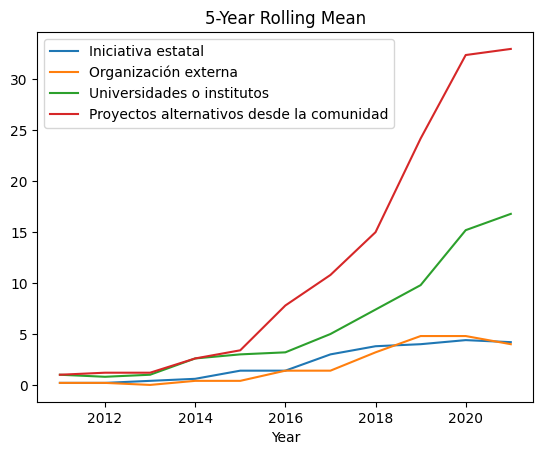

In [276]:
df_mean_5 = df_num_proyectos.rolling(5).mean().dropna()

df_mean_5.plot()
plt.title('5-Year Rolling Mean')
plt.show()

In [277]:
df_mean_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_mean_5.index:
    for column in df_mean_5.columns[:4]:
        df_mean_expanded.loc[len(df_mean_expanded)] = [year, column, df_mean_5.loc[year, column]]

## Modelo inicial

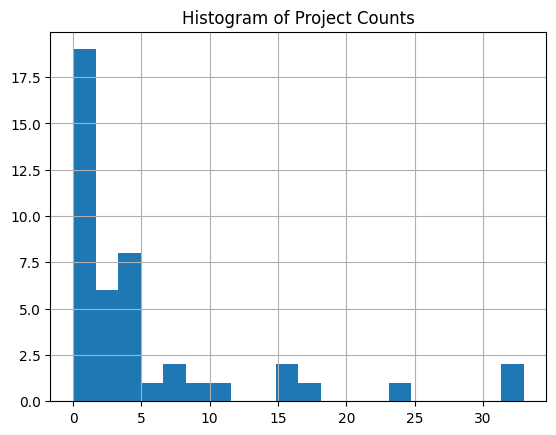

In [279]:
#Histograma de nuestros conteos
df_mean_expanded['Value'].hist(bins=20)
plt.title('Histogram of Project Counts')
plt.show()

El histograma no muestra una distribución normal. Dado que nuestra variable respuesta es un conteo,  se decide usar una regresión de Poisson

In [280]:
df_num_proyectos_by_year = pd.DataFrame(columns=['Year', 'Value'])
for year in df_num_proyectos.index:
    df_num_proyectos_by_year.loc[len(df_num_proyectos_by_year)] = [year, df_num_proyectos.loc[year].sum()]


In [281]:
#Create exposure variable. Foe each row in df_mean_expanded, the exposure will be the value of df_num_proyectos_by_year for the corresponding year
df_mean_expanded['Exposure'] = 0
for i in range(len(df_mean_expanded)):
    year = df_mean_expanded.loc[i, 'Year']
    df_mean_expanded.loc[i, 'Exposure'] = df_num_proyectos_by_year[df_num_proyectos_by_year['Year'] == year]['Value'].values[0]

In [282]:
poisson_glm = smf.glm('Value ~ Year + Origin', data=df_mean_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68.013
Date:                Thu, 16 May 2024   Deviance:                       12.442
Time:                        10:09:23   Pearson chi2:                     11.9
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [283]:
#Probamos equidispersion
print('Variance:',df_mean_expanded['Value'].var())
print('Mean:',df_mean_expanded['Value'].mean())
print('Variance/Mean:',df_mean_expanded['Value'].var()/df_mean_expanded['Value'].mean())

Variance: 62.4322198731501
Mean: 5.518181818181818
Variance/Mean: 11.313911344392936


Para tratar la sobredispersión se usará una regresión binomial negativa. Calculamos primero el parámetro alfa a usar

In [284]:
df_mean_expanded['Lambda'] = poisson_glm.mu
df_mean_expanded['AUX_OLS'] = df_mean_expanded.apply(lambda x: ((x['Value'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
ols_expr = """AUX_OLS ~ Lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_mean_expanded).fit()
print(aux_olsr_results.params)  

Lambda   -0.032364
dtype: float64


Se valida la significancia del alfa conseguido

In [285]:
print(aux_olsr_results.tvalues)
print(poisson_glm.df_resid)

#T-Value (right-tailed): 1.669402
degrees_of_freedom = poisson_glm.df_resid
from scipy.stats import t
alpha = 0.05
t_to_compare=t.ppf(1-alpha, degrees_of_freedom)

if aux_olsr_results.tvalues[0] > t_to_compare:
    print('The alpha parameter is significant')
else:
    print('The alpha parameter is not significant')

alpha = aux_olsr_results.params[0]

Lambda   -2.752919
dtype: float64
39
The alpha parameter is not significant


## Modelo con binomial negativa

In [286]:
df_mean_expanded = df_mean_expanded.drop(columns=['Lambda', 'AUX_OLS'])

In [287]:
alpha=aux_olsr_results.params[0]

# Fit the model again
nbinomial_glm = smf.glm('Value ~ Year + Origin', data=df_mean_expanded, family=sm.families.NegativeBinomial(alpha=0.1)).fit()

# Print the summary
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73.685
Date:                Thu, 16 May 2024   Deviance:                       7.9895
Time:                        10:09:40   Pearson chi2:                     7.46
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9899
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [288]:
from scipy import stats

# Calculate Pearson's chi-squared statistic
pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 0.1912573645714319
Pearson's Chi-Squared = 7.459037218285843
p-value = 0.9999999923989161
Model is not overdispersed


In [289]:
from sklearn.metrics import mean_squared_error

df_naive_mean = df_mean_5.copy()

for column in df_num_proyectos.columns:
    df_naive_mean[column] = df_naive_mean[column].mean()

    # Get the actual and forecasted values
    actual = df_mean_5[column].values
    naive_mean = df_naive_mean[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive_mean))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for Iniciativa estatal: 1.6604290991753998
Naive RMSE for Organización externa: 1.8416665108509962
Naive RMSE for Universidades o institutos: 5.428178697034776
Naive RMSE for Proyectos alternativos desde la comunidad: 11.87299178321528


## Comparar modelos

In [290]:
# Print AIC and BIC for Poisson model
print('Poisson model AIC:', poisson_glm.aic)
print('Poisson model BIC:', poisson_glm.bic)

# Print AIC and BIC for Negative Binomial model
print('Negative Binomial model AIC:', nbinomial_glm.aic)
print('Negative Binomial model BIC:', nbinomial_glm.bic)

Poisson model AIC: 146.02563090327953
Poisson model BIC: -135.14184343845568
Negative Binomial model AIC: 157.37041670882743
Negative Binomial model BIC: -139.59386054195213


c:\Users\amy22\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## Predicciones

In [293]:
df_mean_expanded.reset_index(inplace=True)
df_mean_expanded['Predicted'] = nbinomial_glm.predict(df_mean_expanded)
df_mean_expanded['Residuals'] = df_mean_expanded['Value'] - df_mean_expanded['Predicted']

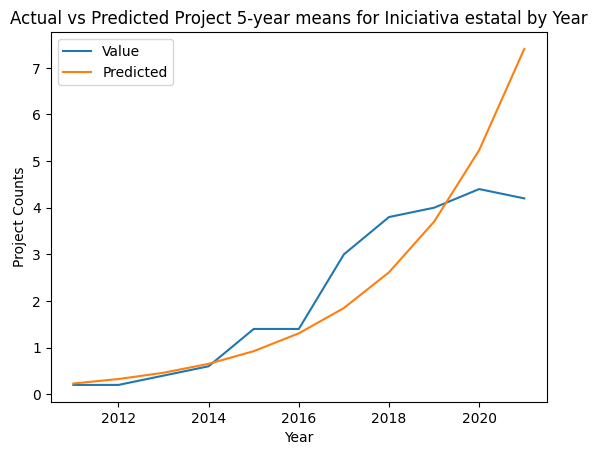

In [292]:
# Set 'Year' as the index
df_mean_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_mean_expanded[df_mean_expanded['Origin']=='Iniciativa estatal'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project 5-year means for Iniciativa estatal by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [294]:
# get rmse for each prediction
for column in df_num_proyectos.columns:
    actual = df_mean_expanded[df_mean_expanded['Origin']==column]['Value']
    predicted = df_mean_expanded[df_mean_expanded['Origin']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for Iniciativa estatal: 1.1301495692795334
RMSE for Organización externa: 0.9327521788834761
RMSE for Universidades o institutos: 1.132428519479491
RMSE for Proyectos alternativos desde la comunidad: 2.8563091107142906


In [295]:
#Now predict until 2024
df_future = pd.DataFrame(columns=['Year', 'Origin'])
for year in range(2019,2028):
    for column in df_num_proyectos.columns[:4]:
        df_future.loc[len(df_future)] = [year, column]

df_future['Predicted'] = nbinomial_glm.predict(df_future)
df_future.set_index('Year', inplace=True)


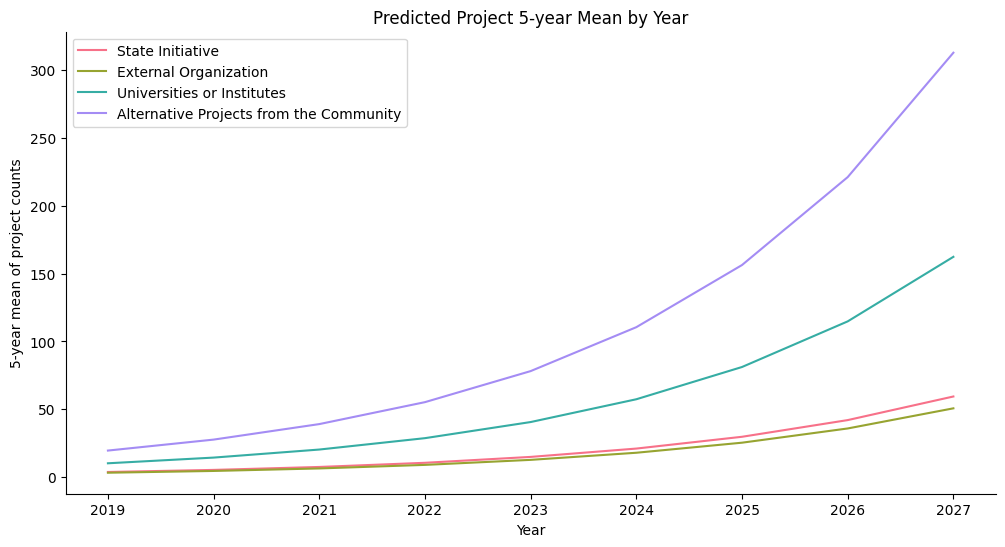

In [297]:
#plot for each origin in the same figure
# Create a color dictionary
color_dict = {
    'Iniciativa estatal': sns.color_palette("husl", 4)[0],
    'Organización externa': sns.color_palette("husl", 4)[1],
    'Universidades o institutos': sns.color_palette("husl", 4)[2],
    'Proyectos alternativos desde la comunidad': sns.color_palette("husl", 4)[3]
}

translation_dict = {
    'Iniciativa estatal': 'State Initiative',
    'Organización externa': 'External Organization',
    'Universidades o institutos': 'Universities or Institutes',
    'Proyectos alternativos desde la comunidad': 'Alternative Projects from the Community'
}


# Plot for each origin in the same figure
fig = plt.figure(figsize=(12, 6))
for column in df_num_proyectos.columns[:4]:
    df_future[df_future['Origin']==column]['Predicted'].plot(label=f'{column}', color=color_dict[column])
plt.title('Predicted Project 5-year Mean by Year')
plt.xlabel('Year')
plt.ylabel('5-year mean of project counts')
plt.legend()
#Rename the legend
for t in plt.gca().get_legend().texts:
    t.set_text(translation_dict[t.get_text()])
#Despine
sns.despine()
plt.savefig('../plots/predicted5YearMeanWithNegativeBinomial.png', bbox_inches='tight')
plt.show()


# Modelo Poisson frecuencia absoluta

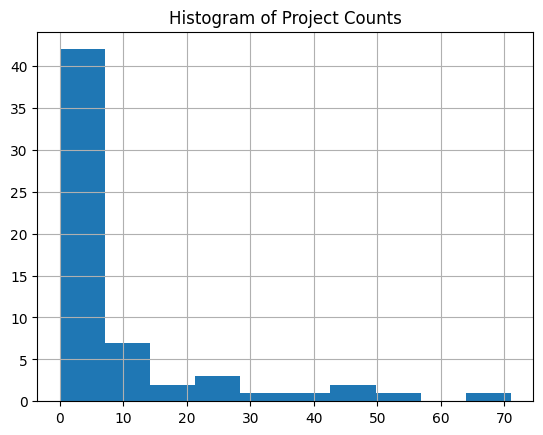

In [203]:
#Histograma de nuestros conteos
df_num_proyectos_expanded['Value'].hist(bins=10)
plt.title('Histogram of Project Counts')
plt.show()

Al igual que antes, la distribución está fuertemente sesgada hacia la izquierda. Se decide usar una regresión de Poisson

In [204]:
df_num_proyectos_expanded['Exposure'] = 0
for i in range(len(df_num_proyectos_expanded)):
    year = df_num_proyectos_expanded.loc[i, 'Year']
    df_num_proyectos_expanded.loc[i, 'Exposure'] = df_num_proyectos_by_year[df_num_proyectos_by_year['Year'] == year]['Value'].values[0]

In [205]:
poisson_glm = smf.glm('Value ~ Year + Origin', data=df_num_proyectos_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -310.52
Date:                Fri, 19 Apr 2024   Deviance:                       474.33
Time:                        10:48:14   Pearson chi2:                     566.
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [206]:
#Probamos equidispersion
print('Variance:',df_num_proyectos_expanded['Value'].var())
print('Mean:',df_num_proyectos_expanded['Value'].mean())
print('Variance/Mean:',df_num_proyectos_expanded['Value'].var()/df_num_proyectos_expanded['Value'].mean())

Variance: 228.48898305084745
Mean: 8.95
Variance/Mean: 25.52949531294385


También hay sobredispersión, por lo que se usará una regresión binomial negativa. Calculamos el alfa a usar

In [207]:
df_num_proyectos_expanded['Lambda'] = poisson_glm.mu
df_num_proyectos_expanded['AUX_OLS'] = df_num_proyectos_expanded.apply(lambda x: ((x['Value'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
ols_expr = """AUX_OLS ~ Lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_num_proyectos_expanded).fit()
print(aux_olsr_results.params)  

Lambda    0.592593
dtype: float64


In [208]:
print(aux_olsr_results.tvalues)
print(poisson_glm.df_resid)

#T-Value (right-tailed): 1.669402
degrees_of_freedom = poisson_glm.df_resid
from scipy.stats import t
alpha = 0.05
t_to_compare=t.ppf(1-alpha, degrees_of_freedom)

if aux_olsr_results.tvalues[0] > t_to_compare:
    print('The alpha parameter is significant')
else:
    print('The alpha parameter is not significant')

alpha = aux_olsr_results.params[0]

Lambda    2.0224
dtype: float64
55
The alpha parameter is significant


## Modelo con binomial negativa

In [209]:
alpha=aux_olsr_results.params[0]
nbinomial_glm = smf.glm('Value ~ Year + Origin', data=df_num_proyectos_expanded, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -152.20
Date:                Fri, 19 Apr 2024   Deviance:                       88.768
Time:                        10:48:24   Pearson chi2:                     85.9
No. Iterations:                    10   Pseudo R-squ. (CS):             0.8954
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [210]:
# Calculate Pearson's chi-squared statistic
pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 1.5610211187778216
Pearson's Chi-Squared = 85.85616153278019
p-value = 0.004890706486999852
Model is overdispersed


In [211]:
from sklearn.metrics import mean_squared_error
df_naive = df_num_proyectos.copy()

for column in df_num_proyectos.columns:
    df_naive[column] = df_naive[column].mean()
    # Get the actual and forecasted values
    actual = df_num_proyectos[column].values
    naive = df_naive[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for Iniciativa estatal: 15.322314881679379
Naive RMSE for Organización externa: 3.678163793102326
Naive RMSE for Universidades o institutos: 12.627307269916612
Naive RMSE for Proyectos alternativos desde la comunidad: 19.90041875606307


## Comparar modelos

In [212]:
# Print AIC and BIC for Poisson model
print('Poisson model AIC:', poisson_glm.aic)
print('Poisson model BIC:', poisson_glm.bic)

# Print AIC and BIC for Negative Binomial model
print('Negative Binomial model AIC:', nbinomial_glm.aic)
print('Negative Binomial model BIC:', nbinomial_glm.bic)

Poisson model AIC: 631.0456458250356
Poisson model BIC: 249.14178835693454
Negative Binomial model AIC: 314.3922551924646
Negative Binomial model BIC: -136.42069963082645


C:\Users\Maracuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## Predicciones

In [213]:
df_num_proyectos_expanded.reset_index(inplace=True)
df_num_proyectos_expanded['Predicted'] = nbinomial_glm.predict(df_num_proyectos_expanded)
df_num_proyectos_expanded['Residuals'] = df_num_proyectos_expanded['Value'] - df_num_proyectos_expanded['Predicted']

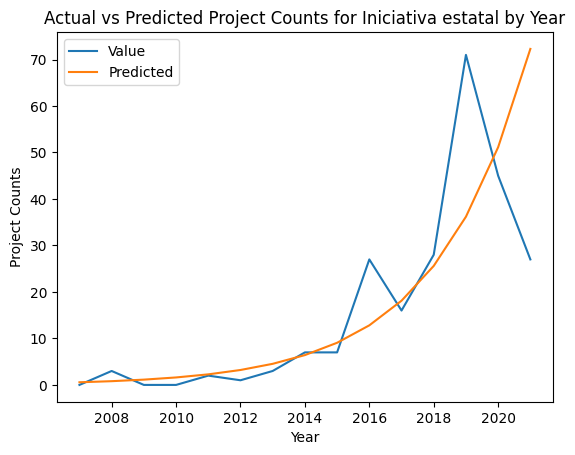

In [214]:
df_num_proyectos_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_num_proyectos_expanded[df_num_proyectos_expanded['Origin']=='Proyectos alternativos desde la comunidad'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project Counts for Iniciativa estatal by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [215]:
for column in df_num_proyectos.columns:
    actual = df_num_proyectos_expanded[df_num_proyectos_expanded['Origin']==column]['Value']
    predicted = df_num_proyectos_expanded[df_num_proyectos_expanded['Origin']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for Iniciativa estatal: 20.366070308062966
RMSE for Organización externa: 4.195284017692695
RMSE for Universidades o institutos: 11.314005517018488
RMSE for Proyectos alternativos desde la comunidad: 15.346166361459028
